###### Content under Creative Commons Attribution license CC-BY 4.0, 2D FD code based on the 2D FV code KelvinHelmholtzInstability by [Philip Mocz](https://pmocz.github.io/) (2016) from [https://github.com/pmocz/KelvinHelmholtzInstability](https://github.com/pmocz/KelvinHelmholtzInstability) under MIT license (c) 2020 Daniel Koehn.

In [1]:
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, 'r').read())

# 2D Euler equations: Kelvin Helmholtz instability

<img src="images/Kelvin-Helmholtz_clouds.jpg" width="95%">

So far, we solved multiple flow problems, from the [Cavity Flow](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/09_Navier_Stokes_2D/01_2D_Navier-Stokes_Cavity_Flow.ipynb) and [Channel Flow](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/09_Navier_Stokes_2D/02_2D_Navier-Stokes_Channel_Flow.ipynb) problems using the 2D Navier-Stokes equations at low Reynolds numbers resulting in laminar flow fields, due to the dominance of viscous forces. More interesting turbulent flow patterns occured when solving the Boltzmann equations, based on a statistical interpretation of particle distributions, [past a cylindrical obstacle at higher Reynolds numbers](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/09_Navier_Stokes_2D/03_2D_Navier-Stokes_Flow_past_obstacles.ipynb).

In this lecture, we will completely neclect the viscous terms in the Navier-Stokes equations, leading to the Euler equations, describing turbulent flow at high Reynolds numbers in the earth atmosphere. For an accurate numerical solution of the Euler equations, I will introduce the Finite-Volume method.

## Governing equations for gas flow

Fluid flow in an incompressible medium consists of the **conservation of mass (continuity)** equation

$$\vec{\nabla} \cdot  \vec{v} = 0$$

and the **Navier-Stokes equations** in vector form for a velocity field $\vec{v}$, 

$$\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\vec{\nabla})\vec{v}=-\frac{1}{\rho}\vec{\nabla} p + \nu \nabla^2\vec{v}$$

with density $\rho $, dynamic viscosity $\nu$ and pressure field $p$. This represents three scalar equations, one for each velocity component $\vec{v} = (u,v,w)$. But we only solved the problem in two dimensions, so there will be two scalar equations.

Modelling of gas flow in the earth atmosphere, requires some modifications of the governing equations. Because gas is compressible, we have to solve the **conservation of mass for a compressible medium**

$$\frac{\partial \rho}{\partial t} + \vec{\nabla} \cdot  \rho \vec{v} = 0.$$

Due to the large  Reynolds numbers of turbulent gas flow, we can neglect the viscous term $\nu \nabla^2\vec{v}$ in the Navier-Stokes equations, leading to the **Euler equations**

$$\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\vec{\nabla})\vec{v}=-\frac{1}{\rho}\vec{\nabla} p,$$

so the non-linear advection term will dominate the problem and leads to some headaches on how to solve the Euler equations.

Finally, we introduce **conservation of energy**, where internal energy is related to the pressure field and a dominant advection energy transport is assumed:

$$\frac{\partial p}{\partial t} + (\vec{v}\cdot \vec{\nabla})p + \gamma p \vec{\nabla}\cdot \vec{v} = 0$$

where $\gamma$ denotes the ideal gas adiabatic index parameter. For a monoatomic ideal  $\gamma = 5/3$.

## The Finite-Volume method

The dominant non-linear advection term of the Euler equations requires a special numerical approach to avoid the numerical diffusion, we experienced, when using the Finite-Difference method. As we have seen in a [previous exercise](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/04_Advection_1D/03_Numerical_Diffusion.ipynb), one solution was to replace the Finite-Difference by the Marker-in-Cell method. 

Another approach is the **Finite-Volume Method** to solve the Euler equations, which is described in this (again) excellent piece [Create Your Own Finite Volume Fluid Simulation (With Python)](https://levelup.gitconnected.com/create-your-own-finite-volume-fluid-simulation-with-python-8f9eab0b8305) by the computational astrophysicist [Philip Mocz](https://pmocz.github.io/) from Princeton university. We will also use his very short and compact [Python-code](https://github.com/pmocz/finitevolume-python) with some minor modifications. 

Let 's try to solve an interesting problem with the Finite-Volume Method.

## Kelvin Helmholtz instability

Assume a high-density region of the atmosphere moving relative to a low-density region in opposite directions. At the interface between the  different regions, a **Kelvin-Helmoltz instability** occurs, leading to a complex vortex and cloud patterns, as shown at the beginning of this notebook. Let 's solve the governing equations to model a Kelvin-Helmholtz instability using the Finite-Volume method ...

In [2]:
import matplotlib.pyplot as plt
import numpy as np

As usual, we first define the modelling parameters ...

In [3]:
# Spatial discretization
Nx = 128
Ny = 128
boxSizeX = 1.
boxSizeY = 1.
dx = boxSizeX / Nx
dy = boxSizeY / Ny
vol = dx*dy
Y, X = np.meshgrid( np.linspace(0.5*dy, boxSizeY-0.5*dy, Ny), np.linspace(0.5*dx, boxSizeX-0.5*dx, Nx) )

# Time discretization
courant_fac = 0.4
t = 0
tEnd = 5

# Slope limiter
useSlopeLimiting = False

... and initial conditions.

In [4]:
# Set initial conditions for KHI
w0 = 0.1
sigma = 0.05/np.sqrt(2.)
gamma = 5/3.
rho = 1. + (np.abs(Y-0.5) < 0.25)
vx = -0.5 + (np.abs(Y-0.5)<0.25)
vy = w0*np.sin(4*np.pi*X) * ( np.exp(-(Y-0.25)**2/(2 * sigma**2)) + np.exp(-(Y-0.75)**2/(2*sigma**2)) )
vz = 0*X
P = 0*X + 2.5

The initial pressure field is constant. To better understand the initial condition for the density field, let's plot it together with the flow field ...

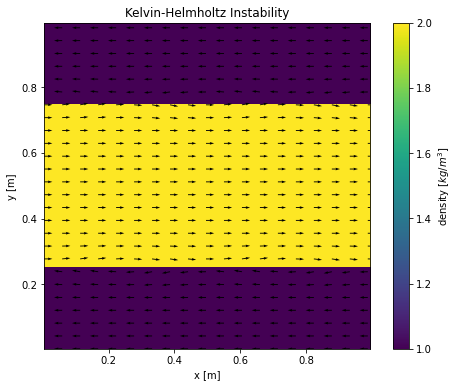

In [5]:
# spatial sample interval for plotting vector arrows
dxs = 7
dys = 5

# Plot initial density distribution & flow field
fig = plt.figure(figsize=(8., 6.))
plt.tight_layout()
extent = [np.min(X), np.max(X),np.min(Y), np.max(Y)]
im = plt.imshow(rho.T, extent=extent, interpolation='none', cmap='viridis')
plt.quiver(X[::dxs,::dys],Y[::dxs,::dys],vx[::dxs,::dys],vy[::dxs,::dys])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Kelvin-Helmholtz Instability')
cbar = plt.colorbar(im)
cbar.set_label(r'density [$kg/m^3$]')

Notice the flow instead the high density region of the atmosphere from left to right and an opposite flow in the regions with lower densities. Finally, we assemble and run the Finite-Volume code to solve the Euler equations ...

<IPython.core.display.Javascript object>


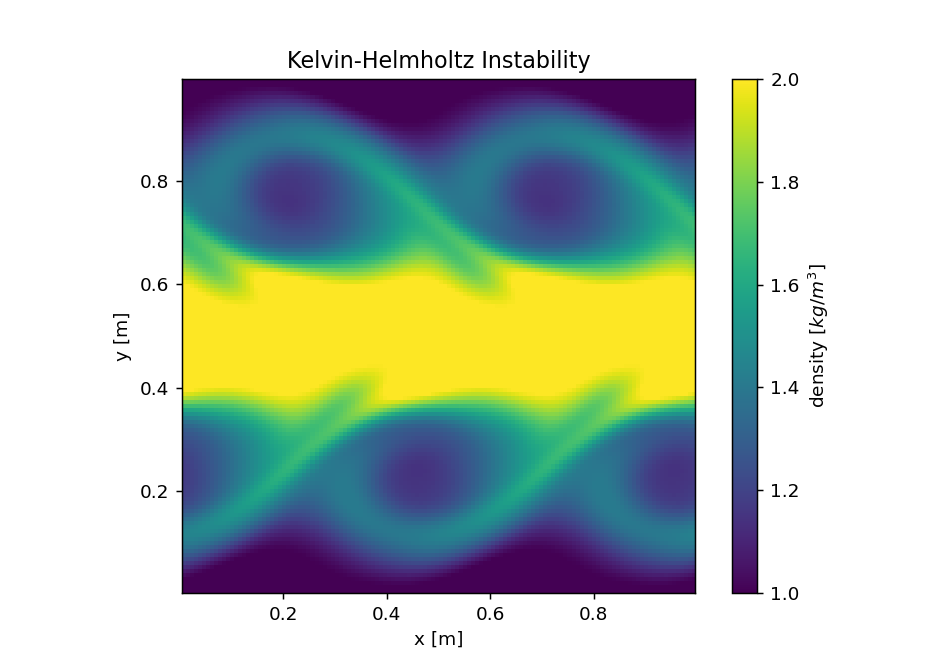

In [6]:
#  Compressible Fluid Dynamics - Finite volume
#  Philip Mocz (2016)   pmocz@cfa.harvard.edu
#  Kelvin Helmholtz Instability (KHI)
# Modified by Daniel Köhn (2020)
%matplotlib notebook
 
# get conserved variables
Mass = rho * vol
Momx = rho * vx * vol
Momy = rho * vy * vol
Energy = (P/(gamma-1) + 0.5*rho*(vx**2+vy**2))*vol

# Plot the initial density distribution
fig = plt.figure(figsize=(7., 5.))
plt.tight_layout()
extent = [np.min(X), np.max(X),np.min(Y), np.max(Y)]
im = plt.imshow(rho.T, extent=extent, interpolation='none', cmap='viridis')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Kelvin-Helmholtz Instability')
cbar = plt.colorbar(im)
cbar.set_label(r'density [$kg/m^3$]')
    
# activate interactive plot
plt.ion()    
plt.show(block=False)  
    
# write density field snapshots every nsnap time steps to image file
nsnap = 16
n = 0

# directions for np.roll() -> central difference FD-operator
R = -1   # right
L = 1    # left

# Main loop
while (t < tEnd):
    
  # get primitive variables
  rho = Mass / vol
  vx = Momx / rho / vol
  vy = Momy / rho / vol
  P = (Energy/vol - 0.5*rho * (vx**2+vy**2)) * (gamma-1)
  
  # get time step (CFL)
  dt = courant_fac * np.min( np.min([dx,dy]) / (np.sqrt( gamma*P/rho ) + np.sqrt(vx**2+vy**2)) )
    
  # calculate gradients
  rho_gradx = ( np.roll(rho,R,axis=0) - np.roll(rho,L,axis=0) ) / (2.*dx)
  rho_grady = ( np.roll(rho,R,axis=1) - np.roll(rho,L,axis=1) ) / (2.*dy)
  vx_gradx  = ( np.roll(vx,R,axis=0) - np.roll(vx,L,axis=0) ) / (2.*dx)
  vx_grady  = ( np.roll(vx,R,axis=1) - np.roll(vx,L,axis=1) ) / (2.*dy)
  vy_gradx  = ( np.roll(vy,R,axis=0) - np.roll(vy,L,axis=0) ) / (2.*dx)
  vy_grady  = ( np.roll(vy,R,axis=1) - np.roll(vy,L,axis=1) ) / (2.*dy)
  P_gradx   = ( np.roll(P,R,axis=0) - np.roll(P,L,axis=0) ) / (2.*dx)
  P_grady   = ( np.roll(P,R,axis=1) - np.roll(P,L,axis=1) ) / (2.*dy)
  
  # slope limit gradients
  if useSlopeLimiting:
    rho_gradx = np.maximum(0., np.minimum(1., ( (rho-np.roll(rho,L,axis=0))/dx)/(rho_gradx + 1.0e-8*(rho_gradx==0)))) * rho_gradx
    rho_gradx = np.maximum(0., np.minimum(1., (-(rho-np.roll(rho,R,axis=0))/dx)/(rho_gradx + 1.0e-8*(rho_gradx==0)))) * rho_gradx
    rho_grady = np.maximum(0., np.minimum(1., ( (rho-np.roll(rho,L,axis=1))/dy)/(rho_grady + 1.0e-8*(rho_grady==0)))) * rho_grady
    rho_grady = np.maximum(0., np.minimum(1., (-(rho-np.roll(rho,R,axis=1))/dy)/(rho_grady + 1.0e-8*(rho_grady==0)))) * rho_grady
    vx_gradx  = np.maximum(0., np.minimum(1., ( (vx-np.roll(vx,L,axis=0))/dx)  /(vx_gradx  + 1.0e-8*(vx_gradx ==0)))) * vx_gradx
    vx_gradx  = np.maximum(0., np.minimum(1., (-(vx-np.roll(vx,R,axis=0))/dx)  /(vx_gradx  + 1.0e-8*(vx_gradx ==0)))) * vx_gradx
    vx_grady  = np.maximum(0., np.minimum(1., ( (vx-np.roll(vx,L,axis=1))/dy)  /(vx_grady  + 1.0e-8*(vx_grady ==0)))) * vx_grady
    vx_grady  = np.maximum(0., np.minimum(1., (-(vx-np.roll(vx,R,axis=1))/dy)  /(vx_grady  + 1.0e-8*(vx_grady ==0)))) * vx_grady
    vy_gradx  = np.maximum(0., np.minimum(1., ( (vy-np.roll(vy,L,axis=0))/dx)  /(vy_gradx  + 1.0e-8*(vy_gradx ==0)))) * vy_gradx
    vy_gradx  = np.maximum(0., np.minimum(1., (-(vy-np.roll(vy,R,axis=0))/dx)  /(vy_gradx  + 1.0e-8*(vy_gradx ==0)))) * vy_gradx
    vy_grady  = np.maximum(0., np.minimum(1., ( (vy-np.roll(vy,L,axis=1))/dy)  /(vy_grady  + 1.0e-8*(vy_grady ==0)))) * vy_grady
    vy_grady  = np.maximum(0., np.minimum(1., (-(vy-np.roll(vy,R,axis=1))/dy)  /(vy_grady  + 1.0e-8*(vy_grady ==0)))) * vy_grady
    P_gradx   = np.maximum(0., np.minimum(1., ( (P-np.roll(P,L,axis=0))/dx)    /(P_gradx   + 1.0e-8*(P_gradx  ==0)))) * P_gradx
    P_gradx   = np.maximum(0., np.minimum(1., (-(P-np.roll(P,R,axis=0))/dx)    /(P_gradx   + 1.0e-8*(P_gradx  ==0)))) * P_gradx
    P_grady   = np.maximum(0., np.minimum(1., ( (P-np.roll(P,L,axis=1))/dy)    /(P_grady   + 1.0e-8*(P_grady  ==0)))) * P_grady
    P_grady   = np.maximum(0., np.minimum(1., (-(P-np.roll(P,R,axis=1))/dy)    /(P_grady   + 1.0e-8*(P_grady  ==0)))) * P_grady

  # extrapolate to cell faces (in time & space)
  rho_prime = rho - 0.5*dt *( vx * rho_gradx + rho * vx_gradx + vy * rho_grady + rho * vy_grady)
  rho_XL = rho_prime - rho_gradx * dx/2.  
  rho_XL = np.roll(rho_XL,R,axis=0)
  rho_XR = rho_prime + rho_gradx * dx/2.
  rho_YL = rho_prime - rho_grady * dy/2.  
  rho_YL = np.roll(rho_YL,R,axis=1)
  rho_YR = rho_prime + rho_grady * dy/2.
  vx_prime = vx - 0.5*dt * ( vx * vx_gradx + vy * vx_grady + (1/rho) * P_gradx )
  vx_XL = vx_prime - vx_gradx * dx/2.  
  vx_XL = np.roll(vx_XL,R,axis=0)
  vx_XR = vx_prime + vx_gradx * dx/2.
  vx_YL = vx_prime - vx_grady * dy/2. 
  vx_YL = np.roll(vx_YL,R,axis=1)
  vx_YR = vx_prime + vx_grady * dy/2.
  vy_prime = vy - 0.5*dt * ( vx * vy_gradx + vy * vy_grady + (1/rho) * P_grady )
  vy_XL = vy_prime - vy_gradx * dx/2.
  vy_XL = np.roll(vy_XL,R,axis=0)
  vy_XR = vy_prime + vy_gradx * dx/2.
  vy_YL = vy_prime - vy_grady * dy/2. 
  vy_YL = np.roll(vy_YL,R,axis=1)
  vy_YR = vy_prime + vy_grady * dy/2.
  P_prime = P - 0.5*dt * ( gamma*P * (vx_gradx + vy_grady)  + vx * P_gradx + vy * P_grady )
  P_XL = P_prime - P_gradx * dx/2.  
  P_XL = np.roll(P_XL,R,axis=0)
  P_XR = P_prime + P_gradx * dx/2.
  P_YL = P_prime - P_grady * dy/2.
  P_YL = np.roll(P_YL,R,axis=1)
  P_YR = P_prime + P_grady * dy/2.

  # compute star (averaged) states
  rho_Xstar = 0.5*(rho_XL + rho_XR)
  rho_Ystar = 0.5*(rho_YL + rho_YR)
  momx_Xstar = 0.5*(rho_XL * vx_XL + rho_XR * vx_XR)
  momx_Ystar = 0.5*(rho_YL * vx_YL + rho_YR * vx_YR)
  momy_Xstar = 0.5*(rho_XL * vy_XL + rho_XR * vy_XR)
  momy_Ystar = 0.5*(rho_YL * vy_YL + rho_YR * vy_YR)
  en_Xstar = 0.5*( P_XL/(gamma-1)+0.5*rho_XL * (vx_XL**2+vy_XL**2) + P_XR/(gamma-1)+0.5*rho_XR * (vx_XR**2+vy_XR**2))
  en_Ystar = 0.5*( P_YL/(gamma-1)+0.5*rho_YL * (vx_YL**2+vy_YL**2) + P_YR/(gamma-1)+0.5*rho_YR * (vx_YR**2+vy_YR**2))

  P_Xstar = (gamma-1)*(en_Xstar-0.5*(momx_Xstar**2+momy_Xstar**2)/rho_Xstar)
  P_Ystar = (gamma-1)*(en_Ystar-0.5*(momx_Ystar**2+momy_Ystar**2)/rho_Ystar)
  
  # compute fluxes (local Lax-Friedrichs/Rusanov)
  flux_rho_X = momx_Xstar
  flux_rho_Y = momy_Ystar
  flux_momx_X = momx_Xstar**2/rho_Xstar + P_Xstar
  flux_momx_Y = momy_Ystar * momx_Ystar/rho_Ystar
  flux_momy_X = momx_Xstar * momy_Xstar/rho_Xstar
  flux_momy_Y = momy_Ystar**2/rho_Ystar + P_Ystar
  flux_en_X = (en_Xstar+P_Xstar) * momx_Xstar/rho_Xstar
  flux_en_Y = (en_Ystar+P_Ystar) * momy_Ystar/rho_Ystar
  
  C = np.sqrt(gamma*P_XL/rho_XL) + np.abs(vx_XL)
  C = np.maximum( C, np.sqrt(gamma*P_XR/rho_XR) + np.abs(vx_XR))
  C = np.maximum( C, np.sqrt(gamma*P_YL/rho_YL) + np.abs(vy_YL))
  C = np.maximum( C, np.sqrt(gamma*P_YR/rho_YR) + np.abs(vy_YR))
  
  flux_rho_X = flux_rho_X - C * 0.5 * (rho_XL - rho_XR)
  flux_rho_Y = flux_rho_Y - C * 0.5 * (rho_YL - rho_YR)
  flux_momx_X = flux_momx_X - C * 0.5 * (rho_XL * vx_XL - rho_XR * vx_XR)
  flux_momx_Y = flux_momx_Y - C * 0.5 * (rho_YL * vx_YL - rho_YR * vx_YR)
  flux_momy_X = flux_momy_X - C * 0.5 * (rho_XL * vy_XL - rho_XR * vy_XR)
  flux_momy_Y = flux_momy_Y - C * 0.5 * (rho_YL * vy_YL - rho_YR * vy_YR)
  flux_en_X = flux_en_X - C * 0.5 * ( P_XL/(gamma-1)+0.5*rho_XL * (vx_XL**2+vy_XL**2) - (P_XR/(gamma-1)+0.5*rho_XR * (vx_XR**2+vy_XR**2)))
  flux_en_Y = flux_en_Y - C * 0.5 * ( P_YL/(gamma-1)+0.5*rho_YL * (vx_YL**2+vy_YL**2) - (P_YR/(gamma-1)+0.5*rho_YR * (vx_YR**2+vy_YR**2)))

  # update solution
  Mass = Mass - dt * dy * flux_rho_X
  Mass = Mass + dt * dy * np.roll(flux_rho_X,L,axis=0)
  Mass = Mass - dt * dx * flux_rho_Y
  Mass = Mass + dt * dx * np.roll(flux_rho_Y,L,axis=1)
  Momx = Momx - dt * dy * flux_momx_X
  Momx = Momx + dt * dy * np.roll(flux_momx_X,L,axis=0)
  Momx = Momx - dt * dx * flux_momx_Y
  Momx = Momx + dt * dx * np.roll(flux_momx_Y,L,axis=1)
  Momy = Momy - dt * dy * flux_momy_X
  Momy = Momy + dt * dy * np.roll(flux_momy_X,L,axis=0)
  Momy = Momy - dt * dx * flux_momy_Y
  Momy = Momy + dt * dx * np.roll(flux_momy_Y,L,axis=1)
  Energy = Energy - dt * dy * flux_en_X
  Energy = Energy + dt * dy * np.roll(flux_en_X,L,axis=0)
  Energy = Energy - dt * dx * flux_en_Y
  Energy = Energy + dt * dx * np.roll(flux_en_Y,L,axis=1)
 
  # advance time
  t += dt
  n += 1  
  
  # update temperature/velocity fields and time
  if (n % nsnap) == 0:        
      im.set_data(rho.T)
      fig.canvas.draw()
      # name_snap = "image_out/Conv_2D_" + "%0.*f" %(0,numpy.fix(n+1000)) + ".tiff"
      # pyplot.savefig(name_snap, format='tiff', bbox_inches='tight', dpi=125)

I know that I use this phrase quite extensively: physicists can predict the future. This vortex pattern not only looks really cool, but also  delivers a physical understanding of the cloud pattern you can see at the beginning of this notebook. With 128x128 volume cells, the resolution of this modelling run is quite low. I increased the resolution to 2048x2048 cells and run the same Python code on one CPU core of the [NEC-cluster at the computing center of Kiel University](https://www.rz.uni-kiel.de/en/our-portfolio/hiperf/nesh) for 3d 5h 25m leading to the following time evolution of the density field:

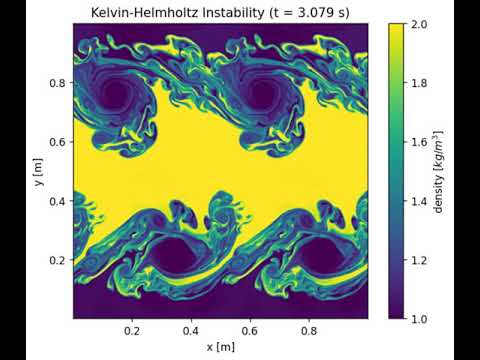

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo('PuSyWarFKsE') 

Wow, that looks even cooler than the previous low-res 128x128 modelling run. Notice the formation and interaction of small vortices in this turbulent gas flow. According to a turbulence theory introduced by [Andrey_Kolmogorov](https://en.wikipedia.org/wiki/Andrey_Kolmogorov) in 1941, energy is transfered from large scale vorticies to small scale vorticities. At the [Kolmogorov microscale](https://en.wikipedia.org/wiki/Kolmogorov_microscales) viscous terms begin to dominate and kinetic energy is dissipated into heat. The energy dissipation leads to a significant problem, because the low-resolution modelling run is not able to resolve the small scale vorticities, resulting in different final density distributions at the final time step.

A prominent example of the Kelvin-Helmholtz instability is the [Great Red Spot](https://en.wikipedia.org/wiki/Great_Red_Spot), which can also be seen [from earth using a small telescope](https://www.flickr.com/photos/daniel_koehn/25615926858/in/album-72157635475504224/lightbox/)

## What we learned:

- When modelling the dynamics of gas flow, we have to consider mass conservation for a compressible medium, a dominant momentum transport by non-linear advection, replacing the Navier-Stokes by the Euler equations and finally energy transport by advection

- An efficient and easy to implement numerical approach to solve this problem is the Finite-Volume method

- The Kelvin-Helmholtz Instability example shows the importance of the model resolution to accurately describe the formation and interacting of small scale vorticies. Especially due to the dissipation of kinetic energy into heat at the Kolomogorov microscale